## Описание датасета:

- Home Ownership - домовладение
- Annual Income - годовой доход
- Years in current job - количество лет на текущем месте работы
- Tax Liens - налоговые обременения
- Number of Open Accounts - количество открытых счетов
- Years of Credit History - количество лет кредитной истории
- Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
- Number of Credit Problems - количество проблем с кредитом
- Months since last delinquent - количество месяцев с последней просрочки платежа
- Bankruptcies - банкротства
- Purpose - цель кредита
- Term - срок кредита
- Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
- Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
- Monthly Debt - ежемесячный долг
- Credit Score - баллы кредитного рейтинга
- Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

## Подключение библиотек, скриптов и директорий

In [1]:
import numpy as np
import pandas as pd
import pickle
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgbm
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix,
                             accuracy_score, classification_report, plot_confusion_matrix,
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve, f1_score)
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def evaluate_preds(model, X_train, X_valid, y_train, y_valid):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    print("TRAIN\n", round(f1_score(y_train, y_train_pred), 3))
    print("TEST\n", round(f1_score(y_valid, y_valid_pred), 3))
    get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

In [5]:
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'
SAMPLE_SUBMIT_PATH = './sample_submission.csv'

## Обзор датасета

In [6]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [7]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [9]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [10]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


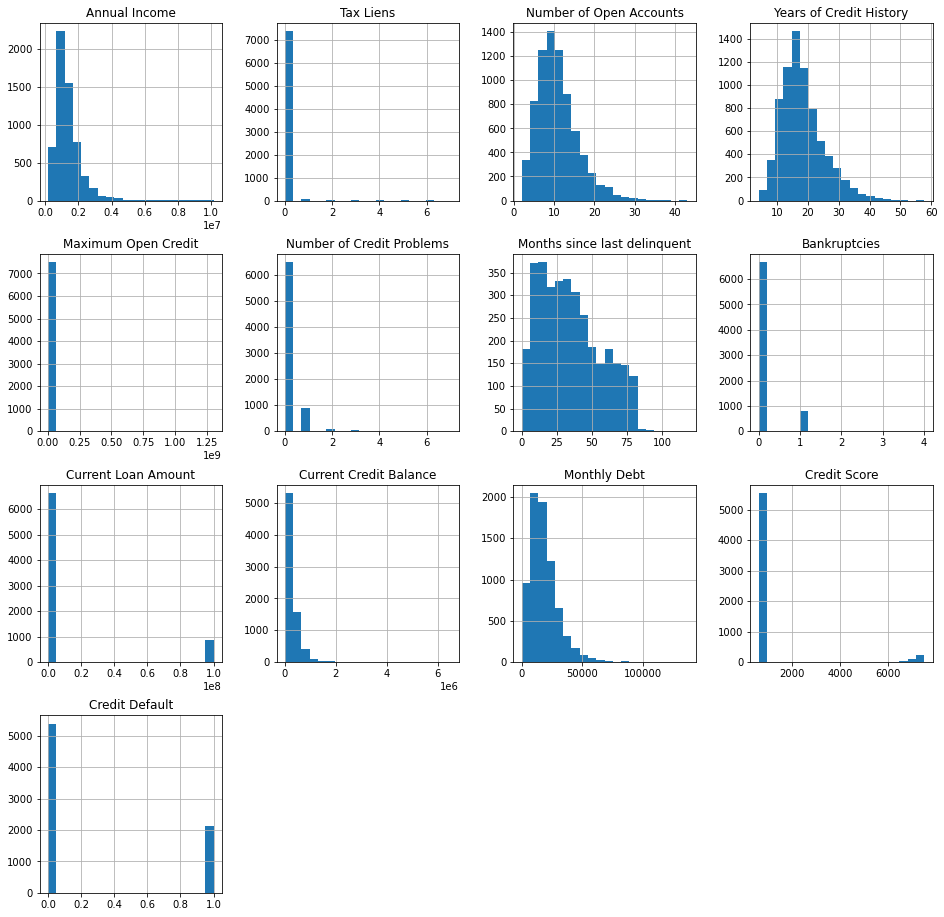

In [11]:
df_train.hist(bins = 20, figsize = (16, 16))
plt.show()

In [12]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

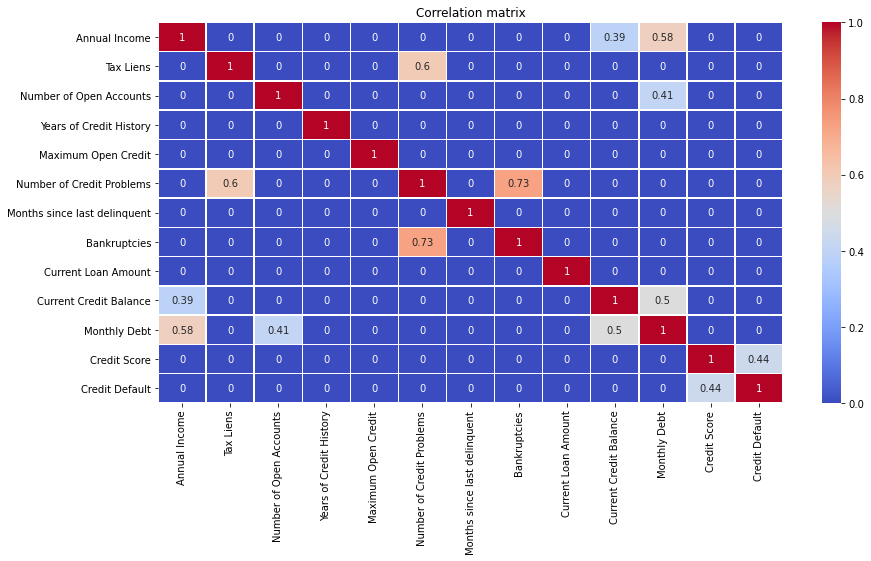

In [13]:
plt.figure(figsize=(14, 7))

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

## Обработка выбросов и пропусков

In [14]:
df_train.loc[df_train['Annual Income'].isna(), 'Annual Income'] = df_train['Annual Income'].median()
df_train.loc[df_train['Maximum Open Credit'] > 99999999.0, 'Maximum Open Credit'] = df_train['Maximum Open Credit'].median()
df_train.loc[df_train['Months since last delinquent'].isna(), 'Months since last delinquent'] = df_train['Months since last delinquent'].median()
df_train.loc[df_train['Bankruptcies'].isna(), 'Bankruptcies'] = df_train['Bankruptcies'].median()
df_train.loc[df_train['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = df_train['Current Loan Amount'].median()
df_train['Years in current job'] = df_train['Years in current job'].replace({'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, 
                                                                             '4 years':4, '5 years':5, '6 years':6, '7 years':7,
                                                                             '8 years':8,'9 years':9,'10+ years':10})
df_train.loc[df_train['Years in current job'].isna(), 'Years in current job'] = df_train['Years in current job'].mode()[0]
df_train.loc[df_train['Credit Score'] > 1000, 'Credit Score'] = df_train['Credit Score'].median()
df_train.loc[df_train['Credit Score'].isna(), 'Credit Score'] = df_train['Credit Score'].median()
df_train['Long Term'] = df_train['Term'].map({'Long Term': 1, 'Short Term': 0})

## Сделаем тоже самое для тестового датасета

In [15]:
df_test.loc[df_test['Annual Income'].isna(), 'Annual Income'] = df_test['Annual Income'].median()
df_test.loc[df_test['Maximum Open Credit'] > 99999999.0, 'Maximum Open Credit'] = df_test['Maximum Open Credit'].median()
df_test.loc[df_test['Months since last delinquent'].isna(), 'Months since last delinquent'] = df_test['Months since last delinquent'].median()
df_test.loc[df_test['Bankruptcies'].isna(), 'Bankruptcies'] = df_test['Bankruptcies'].median()
df_test.loc[df_test['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = df_test['Current Loan Amount'].median()
df_test['Years in current job'] = df_test['Years in current job'].replace({'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, 
                                                                             '4 years':4, '5 years':5, '6 years':6, '7 years':7,
                                                                             '8 years':8,'9 years':9,'10+ years':10})
df_test.loc[df_test['Years in current job'].isna(), 'Years in current job'] = df_test['Years in current job'].mode()[0]
df_test.loc[df_test['Credit Score'] > 1000, 'Credit Score'] = df_test['Credit Score'].median()
df_test.loc[df_test['Credit Score'].isna(), 'Credit Score'] = df_test['Credit Score'].median()
df_test['Long Term'] = df_test['Term'].map({'Long Term': 1, 'Short Term': 0})

## Разбиение признаков и создание модели

In [16]:
FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Long Term']

In [17]:
X = df_train[FEATURE_NAMES]
y = df_train['Credit Default']

In [18]:
df_train = df_train.drop(columns=['Home Ownership', 'Purpose', 'Term', 'Credit Default'])
df_test = df_test.drop(columns=['Home Ownership', 'Purpose', 'Term'])

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42, stratify=y)
display(y_train.value_counts(normalize=True), y_valid.value_counts(normalize=True))

0    0.718209
1    0.281791
Name: Credit Default, dtype: float64

0    0.718384
1    0.281616
Name: Credit Default, dtype: float64

In [20]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5487288135593222

In [21]:
%%time
model_lgbm = lgbm.LGBMClassifier(random_state=21, class_weight={0:1, 1:2.55}, n_estimators=60, max_depth=3, reg_lambda=1.9)
model_lgbm.fit(X_train, y_train)
THRESHOLD = 0.6
evaluate_preds(model_lgbm, X_train,X_valid, y_train, y_valid)

TRAIN
 0.595
TEST
 0.542
TRAIN

              precision    recall  f1-score   support

           0       0.89      0.67      0.76      3609
           1       0.48      0.78      0.60      1416

    accuracy                           0.70      5025
   macro avg       0.68      0.73      0.68      5025
weighted avg       0.77      0.70      0.72      5025

VALID

              precision    recall  f1-score   support

           0       0.85      0.64      0.73      1778
           1       0.44      0.71      0.54       697

    accuracy                           0.66      2475
   macro avg       0.64      0.68      0.64      2475
weighted avg       0.73      0.66      0.68      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1142  636
1                201  496
Wall time: 123 ms


In [22]:
feature_importances = pd.DataFrame(zip(X_train.columns, model_lgbm.feature_importances_), 
                                   columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
12,Credit Score,85
9,Current Loan Amount,77
0,Annual Income,74
5,Maximum Open Credit,40
11,Monthly Debt,34
10,Current Credit Balance,21
4,Years of Credit History,19
3,Number of Open Accounts,17
13,Long Term,15
7,Months since last delinquent,11


In [23]:
df_test.shape

(2500, 14)

In [24]:
submit = pd.read_csv(SAMPLE_SUBMIT_PATH)
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [25]:
predictions = model_lgbm.predict(df_test)
predictions

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

In [26]:
submit['Credit Default'] = predictions

In [28]:
submit.to_csv('course_project_Vorobev.csv', index=False)